<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.891 · Aprendizaje automático · PEC2</p>
<p style="margin: 0; text-align:right;">2024-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 2: Aprendizaje no supervisado

En esta práctica, exploraremos el uso de modelos de lenguaje grandes (LLMs) para la generación de embeddings, aplicaremos técnicas de reducción de dimensionalidad y utilizaremos varios algoritmos de clustering para analizar el feedback de clientes sobre la empresa UPS obtenido de Yelp. Al finalizar, realizaremos un análisis detallado de los resultados obtenidos.

**Importante:** cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato html, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a html desde el menú File $\to$ Download as $\to$ HTML.

**Importante:** existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de cada PEC. Para cambiar el tipo de celda a este tipo, elegid en el menú: Cell $\to$ Cell Type $\to$ Markdown.

**Importante:** no olvidéis poner vuestro nombre y apellidos en la siguiente celda.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong>
</div>

Carlos Toro Peñas

Para la realización de la práctica necesitaremos importar los siguientes módulos:

In [2]:
import json
from typing import List

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tqdm
import umap

seed = 42

C:\desarrollo\python\anaconda\envs\uoc20241pec2\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Carga del conjunto de datos y preprocesado (1.5 puntos)

Se utilizará un dataset de comentarios de clientes sobre la empresa UPS recopilados de [Yelp](https://www.yelp.com/dataset), contenido en el archivo reviews_ups.txt, donde cada línea es una review. Recuerden que puede haber reviews sin contenido, las cuales deberán ser limpiadas durante el preprocesamiento.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> carga las opiniones del archivo en una lista y elimina aquellas opiniones que estén literalmente vacías.
</div>

In [3]:
# In the pacckage there is a file named yelp_academic_dataset_review.json
# This is the one we proceed to open
#filename = 'yelp_academic_dataset_review.json'
filename = 'reviews_stars_ups.json'
data_reviews = []
json_sentences = []
json_stars = []
with open(filename, 'r', encoding="utf8") as file:
    for line  in file:
        data = json.loads(line)
        data_reviews.append(data)
        json_sentences.append(data['text'])
        json_stars.append(data['stars'])
[print(d['text'])  for d in data_reviews if d['text'] == '' or d['text'] == None]

[]

Hoy en día, el análisis de texto en lenguaje natural ha sido revolucionado por los Modelos de Lenguaje Grandes (LLMs), los cuales han reemplazado las técnicas clásicas como TF-IDF y Bag of Words para la representación de texto. Estas técnicas clásicas, aunque útiles, eran limitadas al crear representaciones dispersas y poco contextuales de los textos. En cambio, los LLMs permiten generar representaciones densas o embeddings, que capturan de manera mucho más efectiva el significado semántico de las palabras y las relaciones entre ellas.

Para comprender como funcionan los modelos de lenguaje se recomienda el siguiente video que, en el minuto 12, explica visualmente la parte de embeddings (representación vectorial de palabras o frases) que usaremos en la PEC: https://www.youtube.com/watch?v=wjZofJX0v4M

En esta práctica, vamos a crear una representación densa (embedding) de las reviews utilizando MiniLM, un modelo ligero que ofrece una excelente capacidad para generar embeddings de texto manteniendo un balance entre rendimiento y eficiencia computacional. MiniLM está basado en la arquitectura Transformer, similar a otros modelos más grandes como BERT, pero optimizado para ser más pequeño y rápido, lo que lo hace ideal para tareas como la nuestra. En concreto, utilizaremos la versión "all-MiniLM-L6-v2", que puedes descargar comprimida en un fichero zip desde el siguiente enlace: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/all-MiniLM-L6-v2.zip

Una vez descargado el archivo, debes descomprimirlo y colocar el directorio extraído en el mismo directorio donde se encuentra este notebook, para facilitar su carga.

Para cargar el modelo, utilizaremos la biblioteca sentence-transformers, la cual es una herramienta que facilita el uso de modelos preentrenados para la generación de embeddings de texto. Esta biblioteca está construida sobre modelos como BERT, MiniLM, y otros, y nos permite, con unas pocas líneas de código, transformar frases y textos en representaciones vectoriales de alta calidad. Aquí puedes encontrar más documentación sobre sentence-transformers y el modelo en concreto de MiniLM: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

Al tener el modelo descargado en local sólo es necesario indicar el nombre del directorio descomprimido donde se encuentra el modelo (que coincide con el nombre del modelo).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> carga el modelo de MiniLM y crea el embedding para la frase "Estoy resolviendo la PEC 2"
</div>

In [4]:
sentences = ["Estoy resolviendo la PEC 2"]
model = SentenceTransformer('data')
embeddings = model.encode(sentences)
print("Embeddings creados para la frase 'Estoy resolviendo la PEC 2' con longitud: ".format(len(embeddings)))

Embeddings creados para la frase 'Estoy resolviendo la PEC 2' con longitud: 


Para crear los embeddings de cada una de las frases del dataset, debemos tener en cuenta que este proceso puede ser algo más lento que algunas otras operaciones, ya que implica transformar cada frase en una representación densa a través de un modelo de lenguaje. Dependiendo del tamaño del dataset y de la capacidad de la máquina, el tiempo requerido podría ser de unos 5 minutos en una máquina estándar. Sin embargo, podemos aplicar ciertas optimizaciones para acelerar este proceso.

Una manera eficiente de hacerlo es procesar las frases en lotes (batches) en lugar de procesarlas una por una. La biblioteca sentence-transformers nos permite pasar directamente la lista completa de frases y dividirlas en lotes más pequeños, haciendo que el cálculo de los embeddings sea más rápido al aprovechar la capacidad de paralelización de la máquina. Para esto, podemos utilizar el parámetro batch_size en el método `encode()`. Por ejemplo, si configuramos `batch_size=256`, indicaremos al modelo que procese 256 reviews al mismo tiempo, lo cual acelera el procesamiento considerablemente. Si el proceso es muy lento, puedes reducir este número para que se adapte a las características de tu máquina.

Además, para poder realizar un seguimiento del progreso del cálculo, podemos habilitar una barra de progreso con el parámetro `show_progress_bar=True`. Esto nos permitirá tener una visión clara de cuánto falta para completar el procesamiento, lo cual es especialmente útil cuando trabajamos con datasets grandes.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> calcula el embedding de todas las reviews (no vacías)
</div>

In [5]:
embeddings = model.encode(json_sentences, batch_size=256, show_progress_bar=True)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Cuántas dimensiones tiene el embedding generado por MiniLM?
</div>

In [6]:
print("# rows Embeddings:", np.shape(embeddings)[0])
print("# cols Embeddings:", np.shape(embeddings)[1])


# rows Embeddings: 4485
# cols Embeddings: 384


## Reducción de dimensionalidad (2.5 puntos)

El embedding generado por el modelo tiene una alta dimensionalidad. Aunque esta representación es ideal para capturar relaciones semánticas complejas entre frases, es difícil de interpretar y visualizar directamente debido a la alta cantidad de dimensiones.

Para poder visualizar los embeddings y entender mejor cómo se agrupan las reviews similares, necesitamos reducir la dimensionalidad del espacio a algo más manejable, como 2 dimensiones. Al hacerlo, podemos representar gráficamente las frases en un plano, lo que nos permitirá identificar patrones, clusters de frases similares y relaciones entre diferentes opiniones.

En cuanto a la visualización, dado que tenemos miles de puntos (uno por cada embedding generado), es importante asegurarnos de que el gráfico no se vuelva confuso o demasiado saturado. Para ello, utilizaremos un `scatter` plot de Matplotlib y aprovecharemos el parámetro `alpha=0.1`, el cual ajusta la transparencia de los puntos en el gráfico. Esto nos permitirá visualizar claramente las áreas más densas, ya que donde haya una mayor concentración de puntos, estos se superpondrán y se verán más oscuros, facilitando la identificación de zonas con alta densidad de opiniones similares.

### PCA (Principal Component Analysis)
PCA encuentra las direcciones de mayor varianza en los datos y proyecta los puntos hacia esas direcciones. Es rápida y eficiente, pero cuidado porque en algunos casos puede no capturar bien las relaciones no lineales presentes en los embeddings.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> reduce a 2 dimensiones cada una de las reviews y visualiza el resultado donde el color de cada punto se corresponda con las estrellas de esa review. Añade una leyenda para poder interpretar los colores.
</div>

### t-SNE (t-distributed Stochastic Neighbor Embedding)
t-SNE es una técnica para reducir la dimensionalidad preservando las relaciones locales (es decir, mantiene los puntos similares cerca unos de otros). Aunque es más lento que PCA, t-SNE no proyecta linealmente.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> reduce a 2 dimensiones cada una de las reviews y visualiza el resultado donde el color de cada punto se corresponda con las estrellas de esa review. Añade una leyenda para poder interpretar los colores.
</div>

In [31]:
colors = ['mistyrose', 'salmon', 'red', 'firebrick', 'maroon']
def plot_embedding_scattered(embedding):
    ccolors = [l-1 for l in colors]
    x = [embeb[0] for embeb in embedding]
    y = [embeb[1] for embeb in embedding]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    #colormap = np.array([ 'gainsboro', 'silver', 'gray', 'dimgray', 'black'])
    colormap = np.array([ 'mistyrose', 'salmon', 'red', 'firebrick', 'maroon'])
    labels = [ "1 star", "2 stars", "3 stars", "4 stars", "5 stars"]
    ax.scatter(x, y, c=colormap[ccolors], alpha=.2)
    plt.legend(labels , loc='upper left')
    plt.show()

##### Tomamos 5 componentes de proximidad: perplexity = 5

In [30]:
X_embedded = PCA(n_components=2).fit_transform(embeddings)

print("# rows after UMAP:", np.shape(X_embedded)[0])
print("# cols after UMAP:", np.shape(X_embedded)[1])

# rows after UMAP: 4485
# cols after UMAP: 2


In [26]:
plot_embedding_scattered(X_embedded)

NameError: name 'plot_embedding_scattered' is not defined

### UMAP (Uniform Manifold Approximation and Projection)
UMAP es una alternativa relativamente nueva que, al igual que t-SNE, trata de mantener las relaciones locales, pero suele ser más rápido y permite una mayor flexibilidad para ajustar la precisión de los resultados.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> reduce a 2 dimensiones cada una de las reviews y visualiza el resultado donde el color de cada punto se corresponda con las estrellas de esa review. Añade una leyenda para poder interpretar los colores.
</div>

In [16]:
Umap_embedded = umap.UMAP(n_components=2, init='random').fit_transform(embeddings)
print("# rows after UMAP:", np.shape(Umap_embedded)[0])
print("# cols after UMAP:", np.shape(Umap_embedded)[1])

# rows after UMAP: 4485
# cols after UMAP: 2


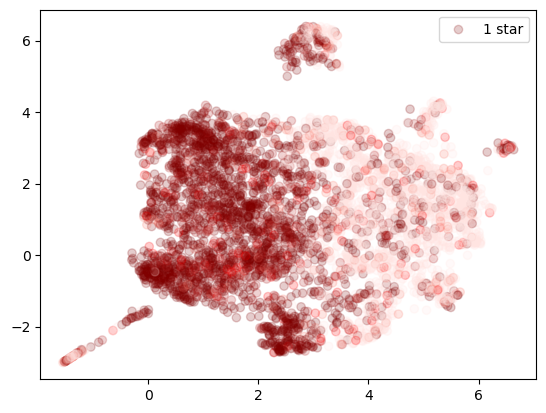

In [17]:
plot_embedding_scattered(Umap_embedded)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué has observado tras su aplicación? Pese a no haber usado la información de las estrellas al realizar los embeddings ¿parece existir una relación entre la disposición de los embeddings y el número de estrellas?
</div>

Está claro que todos los gráficos hay una distribución no aleatoria, parece que los comentarios con valoraciones más positivas han quedado en un lado del gráfico en todos los casos: esto quiere decir que las palabras con significado positivo indican comentarios con mayor número de estrellas.

"Buenos comentarios son indicativos de alto número de estrellas en su valoración". O bien <strong>existe una correlación entre comentarios positivos y valoraciones positivas </strong> que puede apreciarse en todos los gráficos, aunque en alguno con mayor claridad.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Si tuvieses que reducir la dimensionalidad para aplicar posteriormente un modelo de aprendizaje supervisado que se entrenará una vez y en producción hará predicciones diarias. ¿Qué ventajas y desventajas tendría cada uno de los métodos? ¿por qué?
</div>

El segundo de los métodos es, con diferencia el más lento de los tres. Aunque como vemos si comparamos el primer y el segundo de los gráficos, ambos tienen casi la misma distribución (aunque con diferentes tamaños).

 El primer método, aunque más eficiente que el segundo, ofrece mayores errores de cálculo pues hace 
 
 UMAP lento que PCA, ya que al preservar las relaciones locales hace muchas mas operaciones, sin embargo tambéen se ha mostrado superior en la separación de las clases con mayor eficiencia.

 El tercero de los métodos, <strong>UMAP</strong> es definitivamente el que yo escogería, pues preserva las relaciones locales y es mucho más rápido en su ejecución que TSNE.

### Validación en 3 dimensiones

Después de visualizar la reducción a dos dimensiones, elige el método de reducción de dimensionalidad que consideres más adecuado.
Luego, valida que las estructuras identificadas se mantienen al extender la visualización a tres dimensiones. Esta validación permite agregar más información y verificar si los patrones observados persisten cuando se incorpora una dimensión adicional, lo cual proporciona una visión más completa de la organización de los datos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> crea un nuevo embedding proyectando a 3 dimensiones con el método elegido y visualiza con matplotlib manteniendo el color como indicativo del número de estrellas de cada review.
</div>

In [22]:
Umap_embedded3D = umap.UMAP(n_components=3, init='random').fit_transform(embeddings)
Umap_embedded3D.shape
print("# rows after UMAP:", np.shape(Umap_embedded3D)[0])
print("# cols after UMAP:", np.shape(Umap_embedded3D)[1])

# rows after UMAP: 4485
# cols after UMAP: 3


In [24]:
def plot_embedding_scattered3D(embedding):
    ccolors = [l-1 for l in colors]
    x = [embeb[0] for embeb in embedding]
    y = [embeb[1] for embeb in embedding]
    z = [embeb[2] for embeb in embedding]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    #colormap = np.array([ 'gainsboro', 'silver', 'gray', 'dimgray', 'black'])
    colormap = np.array([ 'mistyrose', 'salmon', 'red', 'firebrick', 'maroon'])
    labels = [ "1 star", "2 stars", "3 stars", "4 stars", "5 stars"]
    ax.scatter(x, y, z, c=colormap[ccolors], alpha=.2)
    plt.legend(labels , loc='upper left')
    plt.show()
plot_embedding_scattered3D(Umap_embedded3D) 


TypeError: unsupported operand type(s) for -: 'str' and 'int'

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Es coherente esta visualización con lo observado en la figura 2d?
</div>

Si, es coherente, incluso puede observarse el mismo comportamiento con algo más de claridad: la distribución no es aleatoria, los comentarios más positivos han quedado a un lado del gráfico.
Por tanto, sigue siendo coherente con lo visto en la figura en 2D: continúa la correlación entre estrellas y palabras.

### Dendrograma

Además de la visualización de los datos en 2 dimensiones mediante métodos de reducción de dimensionalidad, podemos también tratar de entender cómo se distribuyen los puntos en el espacio de alta dimensionalidad utilizando una técnica diferente: el **dendrograma**.

Un dendrograma es una **representación gráfica que muestra la estructura jerárquica de un conjunto de datos**. Este tipo de gráfico es especialmente útil para entender las relaciones entre puntos de datos cuando queremos agruparlos de manera jerárquica. El dendrograma se genera como parte del algoritmo de clustering jerárquico, el cual intenta agrupar los datos de manera recursiva, creando una estructura en forma de árbol donde cada hoja representa un punto del dataset y cada bifurcación representa la unión de dos grupos.

Cómo interpretar un dendrograma:

En la parte inferior del dendrograma, cada hoja representa un dato individual (en este caso, una review).
- A medida que nos movemos hacia arriba, los puntos que están más cercanos entre sí se van agrupando, y esos grupos se unen en niveles superiores hasta que, eventualmente, todos los puntos se juntan en un único grupo en la parte superior.
- Las distancias verticales indican la similitud o disimilitud entre los grupos que se están uniendo. Cuanto mayor es la altura a la que se unen dos grupos, mayor es la disimilitud entre ellos. Por lo tanto, un dendrograma nos da una idea visual de qué puntos están más cerca unos de otros y cómo los clusters más pequeños se fusionan para formar clusters más grandes.
- Utilizando un dendrograma, podemos decidir cuántos clusters tiene sentido crear, observando dónde sería adecuado cortar el árbol. Por ejemplo, si encontramos un punto donde los grupos se empiezan a unir con una gran distancia, podría indicar que ese es un buen lugar para cortar y definir el número de clusters.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> visualiza el dendrograma teniendo en cuenta estos parámetros:
<ul>
<li><strong>truncate_mode='level'</strong>: limita la profundidad del dendrograma, mostrando solo un número determinado de niveles de unión, lo cual es útil para evitar un gráfico excesivamente complejo.

<li><strong>p=200</strong>: cuántos clusters o niveles se mostrarán. En este caso, se visualizarán hasta 500 grupos, permitiendo un buen equilibrio entre detalle y simplicidad.

<li><strong>no_labels=True</strong>: oculta las etiquetas de cada punto para evitar que el gráfico se vea sobrecargado y se genere más rápido.

<li><strong>method='single'</strong>: es una manera intuitiva de agrupar las muestras, pues define la distancia entre dos grupos como la distancia entre los puntos más cercanos en cada grupo.
</ul>
</div>

In [26]:
Z = linkage(embeddings, 'single')

{'icoord': [[205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [185.0, 185.0, 202.5, 202.5],
  [175.0, 175.0, 193.75, 193.75],
  [165.0, 165.0, 184.375, 184.375],
  [155.0, 155.0, 174.6875, 174.6875],
  [145.0, 145.0, 164.84375, 164.84375],
  [135.0, 135.0, 154.921875, 154.921875],
  [125.0, 125.0, 144.9609375, 144.9609375],
  [115.0, 115.0, 134.98046875, 134.98046875],
  [105.0, 105.0, 124.990234375, 124.990234375],
  [95.0, 95.0, 114.9951171875, 114.9951171875],
  [85.0, 85.0, 104.99755859375, 104.99755859375],
  [75.0, 75.0, 94.998779296875, 94.998779296875],
  [65.0, 65.0, 84.9993896484375, 84.9993896484375],
  [55.0, 55.0, 74.99969482421875, 74.99969482421875],
  [45.0, 45.0, 64.99984741210938, 64.99984741210938],
  [35.0, 35.0, 54.99992370605469, 54.99992370605469],
  [25.0, 25.0, 44.999961853027344, 44.999961853027344],
  [15.0, 15.0, 34.99998092651367, 34.99998092651367],
  [5.0, 5.0, 24.999990463256836, 24.999990463256836]],
 'dcoord': [[0.0, 1.0213183460095132, 1

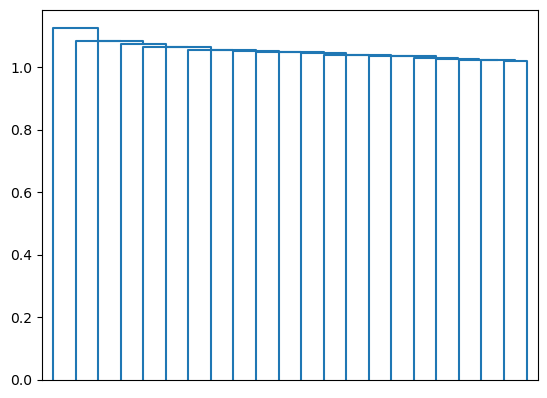

In [31]:
dendrogram(Z, p=20, truncate_mode='level', no_labels=True)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué podemos observar en el dendrograma? ¿Algo similara a los observado en las reducciones de dimensionalidad?
</div>

## Clustering (3 puntos)

Tras haber visualizado el conjunto de datos y examinado el dendrograma, hemos obtenido una visión más profunda sobre la estructura y las relaciones internas del dataset. Esta información nos ayudará a tomar una decisión informada sobre cuál es la mejor estrategia de clustering a seguir. Sin embargo, antes de definir nuestra estrategia final, es importante explorar cómo funcionan distintos algoritmos de clustering, para comprender mejor sus ventajas y limitaciones.

En este contexto, realizaremos algunos experimentos utilizando diferentes algoritmos de clustering. Probaremos enfoques como **K-means**, **clustering jerárquico**, **DBSCAN**, y **Mean-Shift**.

Para ello contamos con los siguientes datasets:

In [32]:
n_samples = 1000
blobs_data, blobs_labels = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=seed)
moons_data, moons_labels = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
circles_data, circles_labels = datasets.make_circles(n_samples=n_samples, factor=0.4, noise=0.05, random_state=seed)

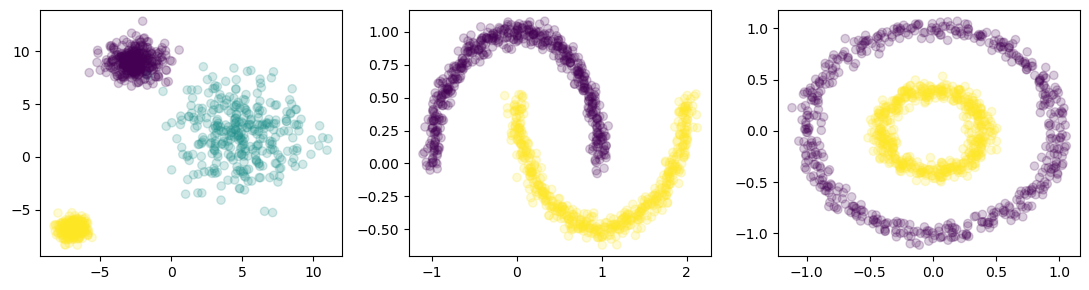

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=blobs_labels, alpha=.2)
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=moons_labels, alpha=.2)
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=circles_labels, alpha=.2)
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica K-means a los tres datasets anteriores y visualiza su resultado.
</div>

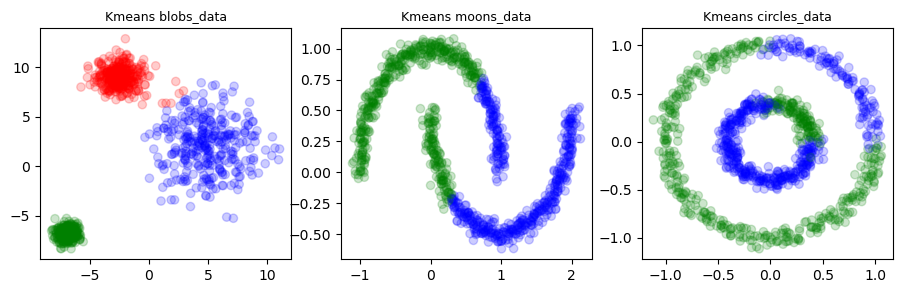

In [34]:
# Kmeans for blobs_data
clusteringKmeans1 = KMeans(n_clusters=3)
clusteringKmeans1.fit(blobs_data)

# Kmeans for moon_data
clusteringKmeans2 = KMeans(n_clusters=2) 
clusteringKmeans2.fit(moons_data)

# Kmeans for circles_data
clusteringKmeans3 = KMeans(n_clusters=2) 
clusteringKmeans3.fit(circles_data)

fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].set_title("Kmeans blobs_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[0].scatter(x=blobs_data[:,0], y=blobs_data[:,1],c=color_theme[clusteringKmeans1.labels_], alpha=.2)

ax[1].set_title("Kmeans moons_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[1].scatter(x=moons_data[:,0], y=moons_data[:,1],c=color_theme[clusteringKmeans2.labels_], alpha=.2)

ax[2].set_title("Kmeans circles_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[2].scatter(x=circles_data[:,0], y=circles_data[:,1],c=color_theme[clusteringKmeans2.labels_], alpha=.2)
plt.show()



<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica clustering jerárquico a los tres datasets anteriores y visualiza su resultado.
</div>

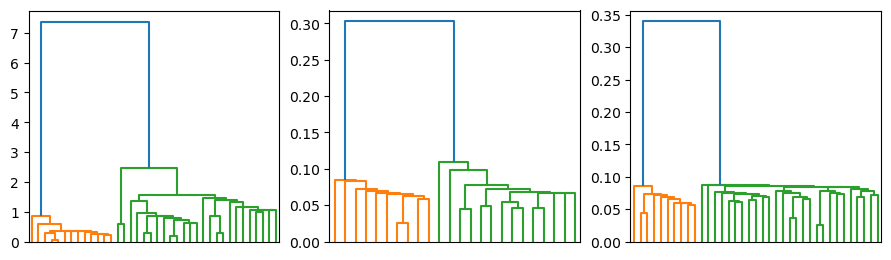

In [35]:
linkage_data_blobs = linkage(blobs_data, method='single', metric='euclidean')
linkage_data_moons = linkage(moons_data, method='single', metric='euclidean')
linkage_data_circles_data = linkage(circles_data, method='single', metric='euclidean')

fig, ax = plt.subplots(1, 3, figsize=(11, 3))
dendrogram(linkage_data_blobs, ax=ax[0], p=10, truncate_mode='level', no_labels=True)
dendrogram(linkage_data_moons, ax=ax[1], p=8, truncate_mode='level', no_labels=True)
dendrogram(linkage_data_circles_data, ax=ax[2], p=8, truncate_mode='level', no_labels=True)

plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica DBSCAN a los tres datasets anteriores y visualiza su resultado.
</div>

El numero de clusters es: 3
El numero de clusters es: 3
El numero de clusters es: 3


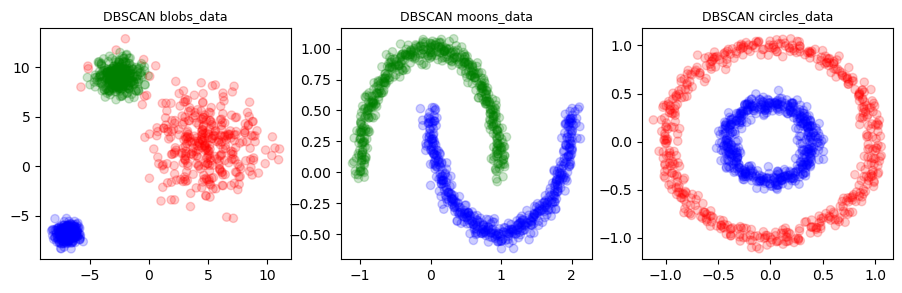

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
clusteringDBSCAN1 = DBSCAN(eps=1, min_samples=45).fit(blobs_data)
cluster = clusteringDBSCAN1.labels_
print("El numero de clusters es: " + str(len(set(cluster))))

clusteringDBSCAN2 = DBSCAN(eps=0.2, min_samples=45).fit(moons_data)
cluster = clusteringDBSCAN1.labels_
print("El numero de clusters es: " + str(len(set(cluster))))

clusteringDBSCAN3 = DBSCAN(eps=0.2, min_samples=45).fit(circles_data)
cluster = clusteringDBSCAN1.labels_
print("El numero de clusters es: " + str(len(set(cluster))))

ax[0].set_title("DBSCAN blobs_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[0].scatter(x=blobs_data[:,0], y=blobs_data[:,1],c=color_theme[clusteringDBSCAN1.labels_], alpha=.2)

ax[1].set_title("DBSCAN moons_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[1].scatter(x=moons_data[:,0], y=moons_data[:,1],c=color_theme[clusteringDBSCAN2.labels_], alpha=.2)

ax[2].set_title("DBSCAN circles_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[2].scatter(x=circles_data[:,0], y=circles_data[:,1],c=color_theme[clusteringDBSCAN3.labels_], alpha=.2)
plt.show()


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplica Mean-shift a los tres datasets anteriores y visualiza su resultado.
</div>

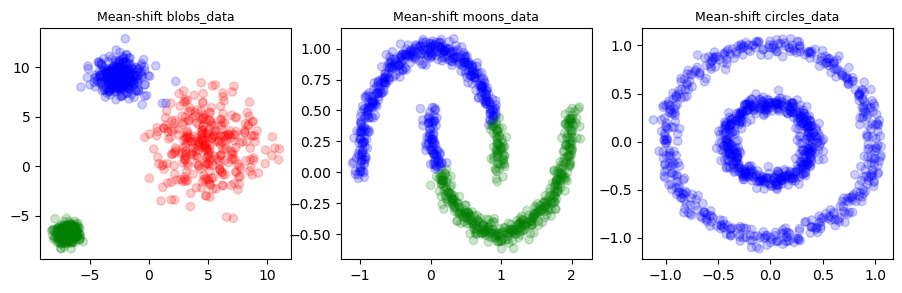

In [37]:
bandwidth = estimate_bandwidth(blobs_data, quantile=0.3)
ms_model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
clusteringMS_blobs = ms_model.fit(blobs_data)

bandwidth = estimate_bandwidth(moons_data, quantile=0.2)
ms_model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
clusteringMS_moons = ms_model.fit(moons_data)

bandwidth = estimate_bandwidth(circles_data, quantile=0.2)
ms_model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
clusteringMS_circles = ms_model.fit(circles_data)

fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].set_title("Mean-shift blobs_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[0].scatter(x=blobs_data[:,0], y=blobs_data[:,1],c=color_theme[clusteringMS_blobs.labels_], alpha=.2)

ax[1].set_title("Mean-shift moons_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[1].scatter(x=moons_data[:,0], y=moons_data[:,1],c=color_theme[clusteringMS_moons.labels_], alpha=.2)

ax[2].set_title("Mean-shift circles_data", fontsize=9)
color_theme = np.array(["blue", "green", "red"])
ax[2].scatter(x=circles_data[:,0], y=circles_data[:,1],c=color_theme[clusteringMS_circles.labels_], alpha=.2)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿En qué casos no se ha podido ajustar el resultado del modelo a los clusters originales? ¿Por qué?
</div>

Vamos uno por uno:

  <strong>1. Kmeans</strong>: ha clasificado correctamente blobs pero no moons ni circles debido a la geometría de cada uno de los conjuntos. No ha sido capaz de encontrar los centroides alrededor de los cuales distinguir cada grupo.
  
  <strong>2. Jerárquico</strong>: ha funcionado bien con moons y circles pues ha interpretado la separación en dos clústeres de estos conjuntos. No ha fucnionado tan bien con blobs, donde la separación en 3 conjuntos no ha sido tan bien interpretada, aunque depende también un poco como interpretemos esta jerarquía.
  
  <strong>3. DBSCAN</strong>: ha clasificado correctamente Todos los conjuntos pues al estar basado en densidad ha clasificado bien aquellos clústeres donde la distancia entre puntos es mínima. Los clústeres han quedado bien diferenciados por esta relacción de densidad.
  
  <strong>4. Mean-shift</strong>: Solo ha funcionado bien con blobs pero no con moons ni con circles, esto es debido a que la geometría de los conjuntos no ha permitido encontrar un hiperplano y menos un bandwith que divida el conjunto en clúsrteres de una manera correcta, esto ha sido dificil para moons pero imposible para circles.

Ahora que has experimentado con varios algoritmos de clustering y comprendido sus ventajas y desventajas, es momento de tomar una decisión importante:

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué algoritmo de clustering seleccionarás para agrupar el conjunto de datos de reviews? ¿Por qué?
</div>

Seleccionaría DBScan pues se ha podido adaptar a todos los modelos y además nos proporciona un modelo real de tamaños y formas de cada conjunto de datos

**Aplícalo al conjunto de datos de reviews**. Si encuentras problemas de rendimiento debido al tamaño del conjunto de datos original, puedes reducir el problema utilizando un conjunto de puntos en 3D en lugar del dato original para que el cálculo sea más rápido y eficiente.


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Aplica el algoritmo de clustering seleccionado al conjunto de datos de reviews y visualiza su resultado. Modifica los parámetros del algoritmo para que se adapte al dato.
</div>

Lo aplicamos a los datos de reviews transformado y codificado: embeddings

In [21]:
clusteringEmbeddings = DBSCAN(eps=0.8, min_samples=45).fit(embeddings)
clusterEmbeddings = clusteringEmbeddings.labels_
print("El numero de clusters es: " + str(len(set(clusterEmbeddings))))

El numero de clusters es: 2


## Análisis de los clusters (3 puntos)

Ahora que has realizado el clustering, es momento de analizar los resultados obtenidos para poder dar insights al negocio.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> revisa la composición de los clusters. <strong>Para cada cluster</strong> identificado, debes mostrar de manera clara y organizada la siguiente información:
<ul>
<li><strong>Número de reviews</strong> asignadas a ese cluster.
<li><strong>Media de estrellas</strong> de las reviews dentro de ese cluster.
<li><strong>Reviews representativas:</strong> selecciona 5 reviews para cada cluster que permitan tener una idea general de su contenido. Si el método de clustering utilizado calcula los centroides (es decir, el "centro" del cluster), selecciona las 5 reviews más cercanas al centroide para una representación más precisa.
Si el método no calcula centroides, simplemente selecciona cualquier 5 reviews del cluster.
</ul>
</div>

El último paso es la interpretación de clusters a través del análisis de las muestras pertenecientes a cada cluster.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Puedes identificar distintos temas o patrones en los mensajes de cada cluster? Comenta la temática de cada cluster.
</div>